In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import pandas as pd

In [2]:
COMPNAME = 6
NCD_FORMULA = "norm-inf-dist-1"

In [16]:
seqs = pd.read_csv("seqs.csv").set_index("seqid").compute()
seqs

,seqpart,seq,lbltype,lbl
seqid,,,,
0,0,[CLS] you ' re going to puerto rico ? ! im so ...,0,0
1,0,"[CLS] * e hug ##z * after ur last 3 updates , ...",0,0
2,0,[CLS] i think gave merge leak ##y ##fl ##u but...,0,0
3,0,[CLS] got my new replacement laptop today ! so...,0,0
4,0,[CLS] geo ##rdi ##es to go down ? [SEP],0,1
...,...,...,...,...
49149,1,[CLS] ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ...,0,1
49150,2,[CLS] fuck . it ' s only in canada right now ....,0,0
49151,2,[CLS] get 100 followers a day using once you a...,0,1


In [25]:
lbls = pd.read_csv("labels.csv").compute()
lbls = { row["seqid"] : row["lbl"] for index, row in lbls.iterrows() }

In [3]:
df = dd.read_csv("graphs.csv")
df = df[(df["compid"] == COMPNAME) & (df["ncd_formula"] == NCD_FORMULA) & (df["seqpart"] == 1)].compute()

In [4]:
df

,lbltype,compid,ncd_formula,dist_aggregator,seqpart,seqid_1,seqid_2,lbl,dist
677770,0,6,norm-inf-dist-1,mp,1,90,91,1,1.509215
677771,0,6,norm-inf-dist-1,mp,1,91,90,1,1.509215
677772,0,6,norm-inf-dist-1,mp,1,90,190,1,1.450336
677773,0,6,norm-inf-dist-1,mp,1,190,90,1,1.450336
677774,0,6,norm-inf-dist-1,mp,1,90,191,1,1.386243
...,...,...,...,...,...,...,...,...,...
865233,0,6,norm-inf-dist-1,mp,1,49148,49051,1,1.655263
865234,0,6,norm-inf-dist-1,mp,1,49051,49149,1,1.456987
865235,0,6,norm-inf-dist-1,mp,1,49149,49051,1,1.456987
865280,0,6,norm-inf-dist-1,mp,1,49148,49149,1,1.301724


In [5]:
n_points = df["seqid_1"].nunique()
NCD = np.zeros((n_points, n_points))
seqids = list(df["seqid_1"].unique())
seqids = dict(map(lambda ij: (ij[1], ij[0]), enumerate(seqids)))
for index, row in df.iterrows():
    i, j = seqids[row["seqid_1"]], seqids[row["seqid_2"]]
    NCD[i, j] = row["dist"]

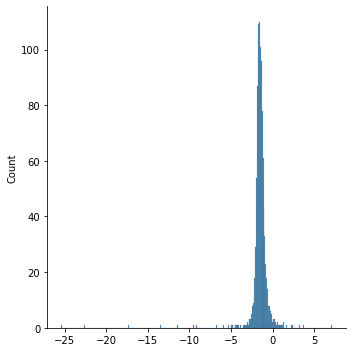

Largest eigenvalue was 1516.9429664662043 (not shown).


In [14]:
ncd_eigs, ncd_eigvs = np.linalg.eigh(NCD)
sns.displot(ncd_eigs[:-1])  # don't show last eigenvalue, ruins the scale
plt.show()
print("Largest eigenvalue was", ncd_eigs[-1], "(not shown).")

In [10]:
n_repeats, n_dim = 100, 10

null_eigs = np.zeros((n_repeats, n_points))
for i in range(n_repeats):
    X = np.random.random((n_points, n_dim))
    D = np.sum(np.abs(X[:, np.newaxis, :] - X[np.newaxis, :, :]), axis=-1)
    assert(D.shape == (n_points, n_points))
    null_eigs[i, :] = np.linalg.eigvalsh(D)

Bulk


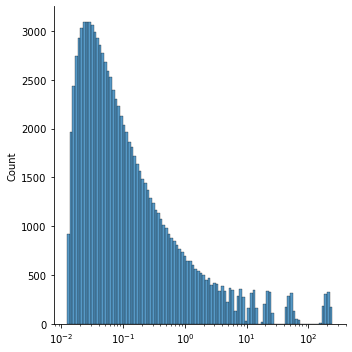

Largest


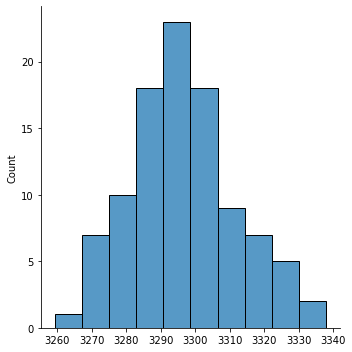

In [12]:
print('Bulk')
sns.displot((-null_eigs[:, :-1]).flatten(), log_scale=True)  # don't show last eigenvalue, ruins the scale
plt.show()
print('Largest')
sns.displot(null_eigs[:, -1])
plt.show()

### Most Negative NCD Eigenvector Analysis

In [34]:
eig_idx = 0
df_eig = pd.DataFrame([
    (seqid, ncd_eigvs[eig_idx, seqids[seqid]], lbls[seqid], seqs[seqs.index == seqid]["seq"].iloc[0])
    for seqid in df["seqid_1"].unique()
], columns=["seqid", "eigv", "lbl", "seq"])
df_eig

,seqid,eigv,lbl,seq
0,90,-0.017555,1,[CLS] ah ##hh ##h . p ##f chang ##s for lunch ...
1,91,0.020273,0,[CLS] u ##gh ##hh . . i want ice ##cre ##am [SEP]
2,190,-0.012147,0,[CLS] sadly needs some followers sob sob ! [SEP]
3,191,-0.023189,0,[CLS] has a major headache [SEP]
4,289,0.016004,0,[CLS] they ' ll miss you . [SEP]
...,...,...,...,...
981,48951,-0.025541,0,[CLS] my eye is sore and i ' ve got a bloody n...
982,49050,0.000913,0,[CLS] is sad for is bank account after that ve...
983,49051,-0.008762,1,[CLS] he ##he ##he how did i miss it all these...
984,49148,0.037377,1,[CLS] om ##g . just saw twilight movie and osc...


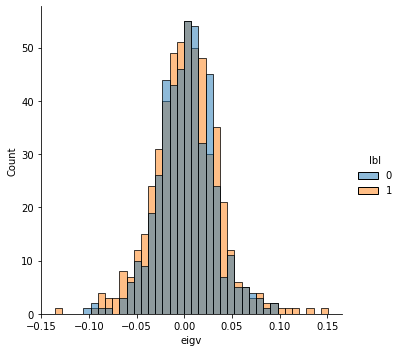

In [33]:
sns.displot(df_eig, x="eigv", hue="lbl")
plt.show()